In [ ]:
import numpy as np
import matplotlib.pyplot as plt



In [22]:
rho = 0.5
T = 200

In [38]:
np.random.seed(111)
x = np.zeros(T)
eps = np.random.normal(0,1,T)

for t in range(1,T):
    x[t] = rho * x[t-1] + eps[t]

In [26]:
x

array([ 0.00000000e+00,  3.84319193e-01,  1.68871337e+00,  4.88974389e-01,
       -5.43046346e-01, -7.30962081e-01, -4.24649812e-01, -5.66498407e-01,
       -1.01877226e+00, -1.69332602e+00, -6.07768874e-01, -8.93804699e-01,
       -1.88748747e+00, -1.70040625e-01, -1.11298764e+00, -6.47480071e-01,
        1.68262967e-01,  5.08803685e-01,  1.53745066e+00,  1.08471178e+00,
        1.34273689e-01, -8.10748616e-04, -9.52832032e-01, -5.87093419e-01,
        2.77047584e-01,  1.05394396e+00, -1.14236853e+00, -8.84706186e-02,
       -3.54707980e-01,  2.21733574e+00,  2.65959879e+00,  6.83334218e-01,
       -5.87270128e-01, -1.94861121e+00, -6.24113101e-01, -4.53813066e-01,
        2.94175254e-01,  1.26186763e-01, -1.68075057e+00, -1.63953416e+00,
       -2.12333751e+00, -8.83563754e-01, -7.76184240e-01, -6.94119250e-01,
       -6.79465199e-01,  1.62321474e+00,  1.53084986e+00,  1.90831144e+00,
        3.03703269e+00,  2.33868592e-01,  6.55061906e-01,  2.82991545e-01,
        2.73866014e+00,  

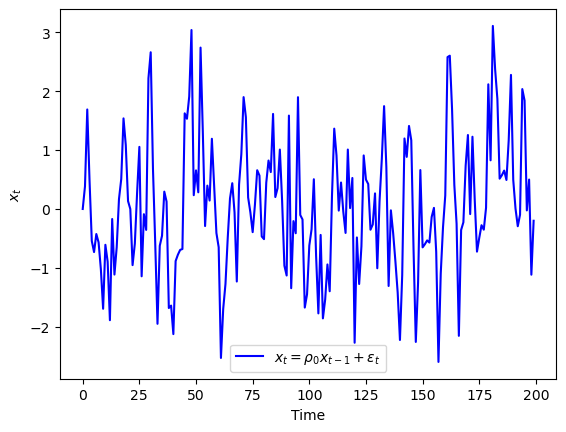

In [45]:
plt.Figure()
plt.plot(x, label=r'$x_t = \rho_0 x_{t-1} + \varepsilon_t$', color = "blue")
plt.xlabel("Time")
plt.ylabel("$x_t$")
plt.legend()
plt.show()